In [362]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
import pickle

# data prep and model-tuning
from sklearn.model_selection import GroupKFold

In [242]:
SAT_DATA = '../data/processed/sentinel_structure_training_data.csv'
sat_df = pd.read_csv(SAT_DATA)
# sat_df.loc[sat_df.qmd > 30, 'qmd'] = 30

LID_DATA = '../data/processed/lidar_structure_training_data.csv'
lid_df = pd.read_csv(LID_DATA)
# lid_df.loc[lid_df.qmd > 30, 'qmd'] = 30

In [328]:
S2_COLS = [col for col in sat_df.columns if col.startswith('S2')]
LANDTRENDR_COLS = [col for col in sat_df.columns if col.startswith('LT')]
SAT_X_COLS = S2_COLS + LANDTRENDR_COLS + ['elevation', 'lat', 'lon']

USE_LIDAR_COLS = ['strat0_return-proportion', 'strat1_return-proportion', 
                  'strat2_return-proportion', 'strat3_return-proportion', 
                  'strat4_return-proportion', 'strat5_return-proportion', 
                  'height_05-percentile',  'height_25-percentile', 
                  'height_50-percentile', 'height_75-percentile',
                  'height_95_percentile', 'cover', 
                  'potential_volume', 'stddev_height', 
                  'surface_volume', 'kurtosis', 'skewness']
LID_X_COLS = USE_LIDAR_COLS + ['elevation', 'lat', 'lon']


Y_COLS = ['total_cover', 'topht', 'qmd', 'tcuft']
Y_NAMES = ['CANOPY COVER (%)', 'DOMINANT HEIGHT (m)', 'QMD (cm)', 'CUBIC VOLUME (m3/ha)']

In [329]:
SAT_MODEL = '../models/structure_models/global-sentinel-HistGradientBoostingRegressor-chained.pkl'
sat_model = pickle.load(open(SAT_MODEL, 'rb'))

LID_MODEL = '../models/structure_models/global-lidar-RandomForestRegressor-chained.pkl'
lid_model = pickle.load(open(LID_MODEL, 'rb'))

In [330]:
CANOPY_BINS = [0,10,40,70,100]
sat_df['cover_class'] = pd.cut(sat_df.total_cover, bins=CANOPY_BINS, include_lowest=True, labels=[0,1,2,3]).astype(int)
lid_df['cover_class'] = pd.cut(lid_df.total_cover, bins=CANOPY_BINS, include_lowest=True, labels=[0,1,2,3]).astype(int)

QMD_BINS = [0,1,5,10,15,20,999]
sat_df['qmd_class'] = pd.cut(sat_df.qmd, bins=QMD_BINS, include_lowest=True, labels=[0,1,2,3,4,5]).astype(int)
lid_df['qmd_class'] = pd.cut(lid_df.qmd, bins=QMD_BINS, include_lowest=True, labels=[0,1,2,3,4,5]).astype(int)

In [331]:
n_samples = len(lid_df)
n_classes = len(lid_df.groupby(['cover_class', 'qmd_class'])['uuid'].count().index)
lid_weights = n_samples / (n_classes * lid_df.groupby(['cover_class', 'qmd_class'])['uuid'].count())

n_samples = len(sat_df)
n_classes = len(sat_df.groupby(['cover_class', 'qmd_class'])['uuid'].count().index)
sat_weights = n_samples / (n_classes * sat_df.groupby(['cover_class', 'qmd_class'])['uuid'].count())

sat_df['weights'] = sat_df.apply(lambda x: sat_weights.loc[(x.cover_class, x.qmd_class)], axis=1)
lid_df['weights'] = lid_df.apply(lambda x: lid_weights.loc[(x.cover_class, x.qmd_class)], axis=1)

In [ ]:
sat_pred = pd.DataFrame(columns=Y_COLS, index=sat_df.index)
groupkfold = GroupKFold(n_splits=5)
groups = sat_df['uuid'].values

for train_index, test_index in groupkfold.split(sat_df[SAT_X_COLS], sat_df[Y_COLS], groups):
    X_train, X_test = sat_df.loc[train_index, SAT_X_COLS], sat_df.loc[test_index, SAT_X_COLS]
    y_train, y_test = sat_df.loc[train_index, Y_COLS], sat_df.loc[test_index, Y_COLS]
#     weights = sat_df.loc[train_index, 'weights'].values
#     sat_model.fit(X_train, y_train, model__sample_weight=weights)
#     sat_model.fit(X_train, np.log(y_train))
#     sat_model.fit(X_train, 1/(y_train))
    sat_model.fit(X_train, y_train)
    
    sat_pred.loc[test_index, Y_COLS] = sat_model.predict(X_test)
#     sat_pred.loc[test_index, Y_COLS] = 1/(sat_model.predict(X_test))
#     sat_pred.loc[test_index, Y_COLS] = np.exp(sat_model.predict(X_test))
    print('.', end='')
print(' Done.')

In [ ]:
lid_pred = pd.DataFrame(columns=Y_COLS, index=lid_df.index)
groupkfold = GroupKFold(n_splits=5)
groups = lid_df['uuid'].values

for train_index, test_index in groupkfold.split(lid_df[LID_X_COLS], lid_df[Y_COLS], groups):
    X_train, X_test = lid_df.loc[train_index, LID_X_COLS], lid_df.loc[test_index, LID_X_COLS]
    y_train, y_test = lid_df.loc[train_index, Y_COLS], lid_df.loc[test_index, Y_COLS]
#     weights = lid_df.loc[train_index, 'weights'].values
#     lid_model.fit(X_train, y_train, model__sample_weight=weights)
#     lid_model.fit(X_train, np.log(y_train))
    lid_model.fit(X_train, y_train)
    lid_pred.loc[test_index, Y_COLS] = lid_model.predict(X_test)
#     lid_pred.loc[test_index, Y_COLS] = np.exp(lid_model.predict(X_test))
    print('.', end='')
print(' Done.')

In [249]:
def fit_gmfr(x, y):
    """Calculates Geometric Mean Functional Relationship (GMFR)
    which represents a best-fit line assuming both x and y values 
    are measured with error.
    
    Paramters
    ---------
    x, y : array of numerics
      values from the datasets to compare
    
    Returns
    -------
    a, b : numerics
      coefficients of the linear relationship y = a + x*b
    """
    # drop nulls
    NULLS = np.logical_or(pd.isnull(x), pd.isnull(y))
    x, y = x[~NULLS], y[~NULLS]
    xbar, ybar = x.mean(), y.mean()
    b = (sum((y - ybar)**2) / sum((x - xbar)**2))**0.5
    a = ybar - b*xbar
    
    return a, b

In [349]:
plot_lid_df = lid_df.merge(lid_pred.astype(float), left_index=True, right_index=True, suffixes=('', '_pred'))
plot_sat_df = sat_df.merge(sat_pred.astype(float), left_index=True, right_index=True, suffixes=('', '_pred'))

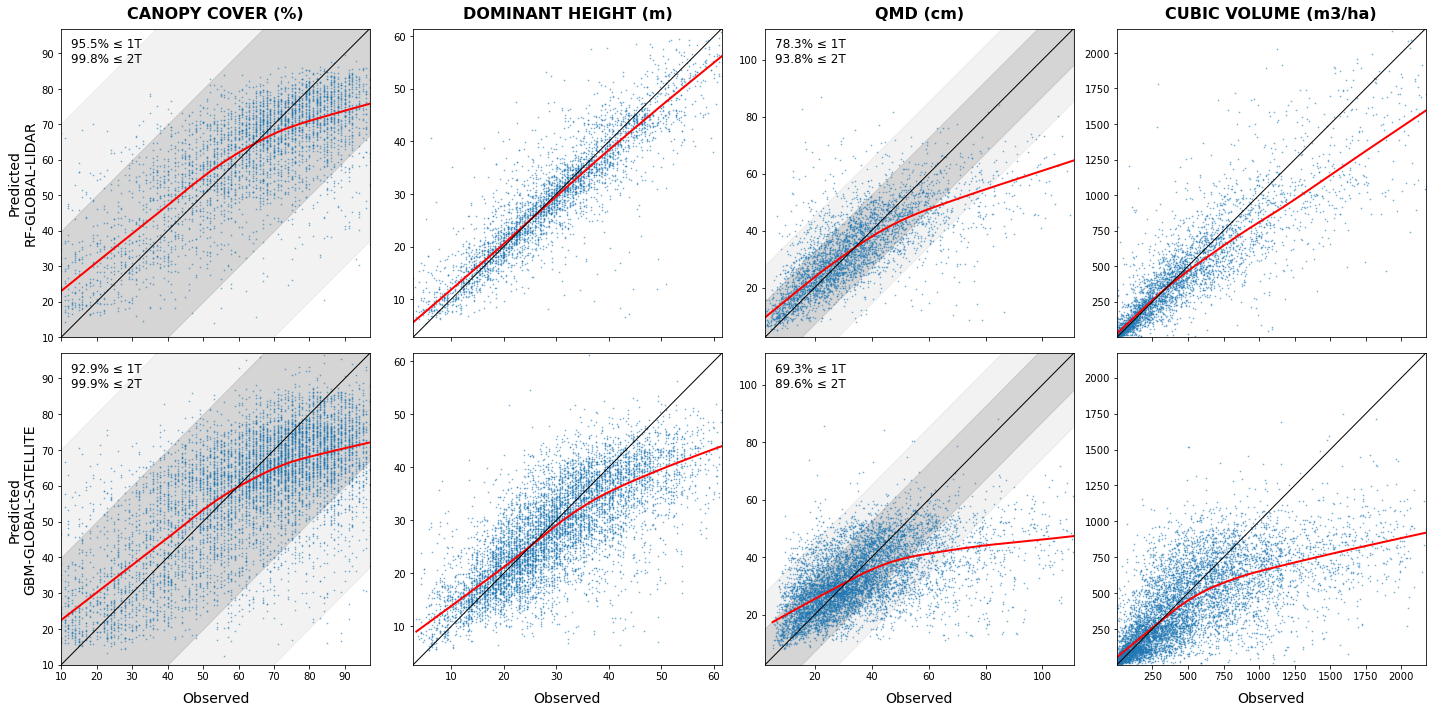

In [398]:
fig, axs = plt.subplots(2,4, figsize=(20,10), sharex='col', sharey='col')
SCALES = [1.0, 0.3048, 2.54, 0.0699725]

for i, col in enumerate(Y_COLS):
    scale = SCALES[i]
    min_val = min(plot_lid_df[col].min(), plot_lid_df[col+'_pred'].min(), plot_sat_df[col].min(), plot_sat_df[col+'_pred'].min())*scale
    max_val = max(plot_lid_df[col].max(), plot_lid_df[col+'_pred'].max(), plot_sat_df[col].max(), plot_sat_df[col+'_pred'].max())*scale
    val_range = (min_val, max_val)
    Q = 0.99
    max_val = max(plot_lid_df[col].quantile(q=Q), 
                  plot_lid_df[col+'_pred'].quantile(q=Q), 
                  plot_sat_df[col].quantile(q=Q), 
                  plot_sat_df[col+'_pred'].quantile(q=Q))*scale
    
    xs = np.linspace(0, max_val, 100)
    lid_x, lid_y = plot_lid_df[col]*scale, plot_lid_df[col+'_pred']*scale
    sat_x, sat_y = plot_sat_df[col]*scale, plot_sat_df[col+'_pred']*scale
    
    axs[0, i].scatter(lid_x, lid_y, s=0.5, alpha=0.5)
    smooth = lowess(lid_y, lid_x).T
    axs[0, i].plot(smooth[0], smooth[1], c='red', label='LOWESS', lw=2.0)
#     # calculate Geometric Mean Functional Relationship (GMFR)
#     a, b = fit_gmfr(lid_x, lid_y)    
#     axs[0, i].plot(xs, a + b*xs, lw=1.0, c='red', label='GMFR line')
    
    axs[1, i].scatter(sat_x, sat_y, s=0.5, alpha=0.5)
    smooth = lowess(sat_y, sat_x, delta=(val_range[1]-val_range[0])*0.01).T
    axs[1, i].plot(smooth[0], smooth[1], c='red', label='LOWESS', lw=2.0)
#     # calculate Geometric Mean Functional Relationship (GMFR)
#     a, b = fit_gmfr(sat_x, sat_y)    
#     axs[1, i].plot(xs, a + b*xs, lw=1.0, c='red', label='GMFR line')
    
    if col in ['total_cover', 'qmd']:
        thresh = 5*scale if col == 'qmd' else 30*scale
        axs[0,i].fill_between(x=[0,max_val], 
                              y1=[0-thresh, max_val-thresh], 
                              y2=[0+thresh, max_val+thresh], 
                              color='gray', alpha=0.25, zorder=0)
        axs[1,i].fill_between(x=[0,max_val], 
                              y1=[0-thresh, max_val-thresh], 
                              y2=[0+thresh, max_val+thresh], 
                              color='gray', alpha=0.25, zorder=0)
        axs[0,i].fill_between(x=[0,max_val], 
                              y1=[0-2*thresh, max_val-(2*thresh)], 
                              y2=[0+2*thresh, max_val+(2*thresh)], 
                              color='gray', alpha=0.10, zorder=0)
        axs[1,i].fill_between(x=[0,max_val], 
                              y1=[0-2*thresh, max_val-(2*thresh)], 
                              y2=[0+2*thresh, max_val+(2*thresh)], 
                              color='gray', alpha=0.10, zorder=0)
        # put a label showing what % of points fall within 1 and 2 thresholds
        resid = abs(lid_y-lid_x)
        within1 = (resid < thresh).sum() / len(lid_x)
        within2 = (resid < (2*thresh)).sum() / len(lid_x)
        axs[0,i].text(0.26, 0.93, f'{within1:.1%} ≤ 1T', ha='right', va='bottom', transform=axs[0,i].transAxes, fontsize=12)
        axs[0,i].text(0.26, 0.88, f'{within2:.1%} ≤ 2T', ha='right', va='bottom', transform=axs[0,i].transAxes, fontsize=12)
        
        resid = abs(sat_y-sat_x)
        within1 = (resid < thresh).sum() / len(sat_x)
        within2 = (resid < (2*thresh)).sum() / len(sat_x)
        axs[1,i].text(0.26, 0.93, f'{within1:.1%} ≤ 1T', ha='right', va='bottom', transform=axs[1,i].transAxes, fontsize=12)
        axs[1,i].text(0.26, 0.88, f'{within2:.1%} ≤ 2T', ha='right', va='bottom', transform=axs[1,i].transAxes, fontsize=12)
    
    axs[0,i].set_aspect('equal')
    axs[0,i].set_title(Y_NAMES[i], fontsize=16, fontweight='bold', pad=10)
    axs[1,i].set_xlabel('Observed', fontsize=14, labelpad=10)
    axs[0,i].plot([0, max_val], [0, max_val], color='black', lw=1.0, label='1:1 line')
    axs[1,i].plot([0, max_val], [0, max_val], color='black', lw=1.0, label='1:1 line')
    axs[0,i].set_xlim(min_val, max_val)
    axs[1,i].set_ylim(min_val, max_val)
    
axs[0,0].set_ylabel('Predicted\nRF-GLOBAL-LIDAR', fontsize=14)
axs[1,0].set_ylabel('Predicted\nGBM-GLOBAL-SATELLITE', fontsize=14)
plt.tight_layout()
plt.savefig('../reports/figures/scatter_obsered_vs_predicted_structure.png', dpi=300)
plt.show()    

In [351]:
for col in Y_COLS:
    plot_lid_df[col+'_resid'] = plot_lid_df[col+'_pred'] - plot_lid_df[col]
    plot_sat_df[col+'_resid'] = plot_sat_df[col+'_pred'] - plot_sat_df[col]

In [352]:
for col in ['total_cover', 'qmd']:
    thresh = 30 if col == 'total_cover' else 5
    plot_lid_df[col+'_within1'] = plot_lid_df[col+'_resid'].apply(lambda x: abs(x) <= thresh)
    plot_lid_df[col+'_within2'] = plot_lid_df[col+'_resid'].apply(lambda x: abs(x) <= 2*thresh)
    plot_sat_df[col+'_within1'] = plot_sat_df[col+'_resid'].apply(lambda x: abs(x) <= thresh)
    plot_sat_df[col+'_within2'] = plot_sat_df[col+'_resid'].apply(lambda x: abs(x) <= 2*thresh)

In [353]:
lid_cover_acc = plot_lid_df.groupby(by=['cover_class'])[['total_cover_within1', 'total_cover_within2']].agg(['sum', 'count'])
sat_cover_acc = plot_sat_df.groupby(by=['cover_class'])[['total_cover_within1', 'total_cover_within2']].agg(['sum', 'count'])

lid_qmd_acc = plot_lid_df.groupby(by=['qmd_class'])[['qmd_within1', 'qmd_within2']].agg(['sum', 'count'])
sat_qmd_acc = plot_sat_df.groupby(by=['qmd_class'])[['qmd_within1', 'qmd_within2']].agg(['sum', 'count'])

In [354]:
lid_cover_acc['within1'] = lid_cover_acc[('total_cover_within1','sum')]/lid_cover_acc[('total_cover_within1','count')]
lid_cover_acc['within2'] = lid_cover_acc[('total_cover_within2','sum')]/lid_cover_acc[('total_cover_within2','count')]
sat_cover_acc['within1'] = sat_cover_acc[('total_cover_within1','sum')]/sat_cover_acc[('total_cover_within1','count')]
sat_cover_acc['within2'] = sat_cover_acc[('total_cover_within2','sum')]/sat_cover_acc[('total_cover_within2','count')]

lid_qmd_acc['within1'] = lid_qmd_acc[('qmd_within1','sum')]/lid_qmd_acc[('qmd_within1','count')]
lid_qmd_acc['within2'] = lid_qmd_acc[('qmd_within2','sum')]/lid_qmd_acc[('qmd_within2','count')]
sat_qmd_acc['within1'] = sat_qmd_acc[('qmd_within1','sum')]/sat_qmd_acc[('qmd_within2','count')]
sat_qmd_acc['within2'] = sat_qmd_acc[('qmd_within2','sum')]/sat_qmd_acc[('qmd_within2','count')]

In [355]:
sat_qmd_acc  ## inverse transformed target

qmd_within1       qmd_within2         within1   within2
                  sum count         sum count                    
qmd_class                                                        
1               274.0   409       383.0   409  0.669927  0.936430
2              1576.0  1997      1944.0  1997  0.789184  0.973460
3              1925.0  2228      2221.0  2228  0.864004  0.996858
4              1068.0  1459      1416.0  1459  0.732008  0.970528
5               337.0  1384       739.0  1384  0.243497  0.533960

In [268]:
sat_qmd_acc  ## log transformed target

qmd_within1       qmd_within2         within1   within2
                  sum count         sum count                    
qmd_class                                                        
1               250.0   409       367.0   409  0.611247  0.897311
2              1485.0  1997      1901.0  1997  0.743615  0.951928
3              1942.0  2228      2208.0  2228  0.871634  0.991023
4              1156.0  1459      1436.0  1459  0.792324  0.984236
5               421.0  1384       831.0  1384  0.304191  0.600434

In [167]:
sat_qmd_acc  ## untransformed target

qmd_within1       qmd_within2         within1   within2
                  sum count         sum count                    
qmd_class                                                        
1               210.0   409       368.0   409  0.513447  0.899756
2              1343.0  1997      1862.0  1997  0.672509  0.932399
3              1879.0  2228      2187.0  2228  0.843357  0.981598
4              1185.0  1459      1433.0  1459  0.812200  0.982180
5               492.0  1384       916.0  1384  0.355491  0.661850

In [187]:
sat_cover_acc ## log transformed target

total_cover_within1       total_cover_within2         within1  \
                            sum count                 sum count             
cover_class                                                                 
0                          18.0    21                21.0    21  0.857143   
1                        1091.0  1232              1232.0  1232  0.885552   
2                        2969.0  3030              3030.0  3030  0.979868   
3                        2975.0  3194              3188.0  3194  0.931434   

              within2  
                       
cover_class            
0            1.000000  
1            1.000000  
2            1.000000  
3            0.998121

In [168]:
sat_cover_acc  ## untransformed target

total_cover_within1       total_cover_within2         within1  \
                            sum count                 sum count             
cover_class                                                                 
0                          16.0    21                21.0    21  0.761905   
1                        1023.0  1232              1231.0  1232  0.830357   
2                        2978.0  3030              3030.0  3030  0.982838   
3                        3060.0  3194              3192.0  3194  0.958046   

              within2  
                       
cover_class            
0            1.000000  
1            0.999188  
2            1.000000  
3            0.999374

In [188]:
lid_qmd_acc  ## log-transformed target

qmd_within1       qmd_within2         within1   within2
                  sum count         sum count                    
qmd_class                                                        
0                 3.0     3         3.0     3  1.000000  1.000000
1               334.0   387       376.0   387  0.863049  0.971576
2               874.0  1037      1006.0  1037  0.842816  0.970106
3               954.0  1083      1063.0  1083  0.880886  0.981533
4               574.0   684       677.0   684  0.839181  0.989766
5               273.0   640       471.0   640  0.426563  0.735938

In [169]:
lid_qmd_acc  ## untransformed target

qmd_within1       qmd_within2         within1   within2
                  sum count         sum count                    
qmd_class                                                        
0                 3.0     3         3.0     3  1.000000  1.000000
1               307.0   387       368.0   387  0.793282  0.950904
2               827.0  1037       993.0  1037  0.797493  0.957570
3               937.0  1083      1056.0  1083  0.865189  0.975069
4               568.0   684       672.0   684  0.830409  0.982456
5               315.0   640       504.0   640  0.492188  0.787500

In [189]:
lid_cover_acc  ## log-transformed target

total_cover_within1       total_cover_within2         within1  \
                            sum count                 sum count             
cover_class                                                                 
0                          11.0    12                12.0    12  0.916667   
1                         551.0   609               609.0   609  0.904762   
2                        1583.0  1601              1601.0  1601  0.988757   
3                        1500.0  1612              1607.0  1612  0.930521   

              within2  
                       
cover_class            
0            1.000000  
1            1.000000  
2            1.000000  
3            0.996898

In [170]:
lid_cover_acc  ## untransformed target

total_cover_within1       total_cover_within2         within1  \
                            sum count                 sum count             
cover_class                                                                 
0                           9.0    12                11.0    12  0.750000   
1                         534.0   609               609.0   609  0.876847   
2                        1588.0  1601              1601.0  1601  0.991880   
3                        1532.0  1612              1611.0  1612  0.950372   

              within2  
                       
cover_class            
0            0.916667  
1            1.000000  
2            1.000000  
3            0.999380